# Predict Future Sales

## Data

In [ ]:
!pip install pyspark

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from google.colab import drive
warnings.simplefilter('ignore')

import seaborn as sns
import sys
import itertools
import gc

import csv
from collections import OrderedDict
from time import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as DecisionTreeRegressorSklearn
from sklearn.linear_model import LinearRegression as LinearRegressionSklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from matplotlib.pyplot import scatter
from sklearn.ensemble import ExtraTreesClassifier

from pyspark.ml.regression import DecisionTreeRegressor as DecisionTreeRegressorSpark
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkConf
from pyspark.ml.regression import LinearRegression as LinearRegressionSpark
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [ ]:
conf = SparkConf()
conf.set("spark.driver.memory", "4g") 
conf.set("spark.driver.maxResultSize", "4g")

In [ ]:
PATH_TO_DATASET = '/content/drive/My Drive/DA/BigDataProject/'
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
items = pd.read_csv(PATH_TO_DATASET + "items.csv")
shops = pd.read_csv(PATH_TO_DATASET + "shops.csv")
cats = pd.read_csv(PATH_TO_DATASET + "item_categories.csv")
train = pd.read_csv(PATH_TO_DATASET + "sales_train.csv")
test = pd.read_csv(PATH_TO_DATASET + "test.csv")

In [ ]:
train.shape

(2935849, 6)

In [ ]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## Data Preprocessing

### Prepare Data



*   Изменение формата даты
*   Объединение одиннаковых магазинов
*   Оставим только магазины, которые встречаются в тестовой выборке
*   Выкинем ошибочные транзакции



In [ ]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

Преобразуем города с помощью LabelEncoder

In [ ]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

label_encoder = LabelEncoder()
shops['city'] = label_encoder.fit_transform(shops['city'])



*   Создадим новое поле "первая дата покупки"
*   Удалим нулевые значения из таблицы



In [ ]:
items['first_sale_date'] = train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items = items.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

Разделим имя категории на отдельные поля типа и подтипа

In [ ]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

Объединим данные из разных таблиц

In [ ]:
train = train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(cats, on='item_category_id', how='left')
test = test.merge(shops, on='shop_id', how='left')
test = test.merge(items, on='item_id', how='left')
test = test.merge(cats, on='item_category_id', how='left')

In [ ]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)
test = test.drop(columns="ID")

In [ ]:
df = pd.concat([train, test])
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = df.merge(group, on=['date_block_num','shop_id','item_id'], how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) 
                                .astype(np.float16))
df = df.drop(['date','shop_name','item_name','item_cnt_day'], axis=1)

In [ ]:
def add_mean(df, idx_features):
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    df = df.merge(group, on=idx_features, how='left')
    
    return df

Добавим столбцы со средними значениями по дате

In [ ]:
df = add_mean(df=df, idx_features=['date_block_num', 'item_id'])
df = add_mean(df=df, idx_features=['date_block_num', 'shop_id'])
df = add_mean(df=df, idx_features=['date_block_num', 'item_category_id'])
df = add_mean(df=df, idx_features=['date_block_num', 'item_id', 'city'])
df = add_mean(df=df, idx_features=['date_block_num', 'shop_id', 'item_category_id'])
df = add_mean(df=df, idx_features=['date_block_num', 'shop_id', 'subtype_code'])

In [ ]:
df['duration_after_first_sale'] = df['date_block_num'] - df['first_sale_date']
df['month'] = df['date_block_num']%12

### Final Dataset

Итоговый датасет для обучения имеет вид

In [ ]:
df.head(10)

,date_block_num,shop_id,item_id,item_price,city,item_category_id,first_sale_date,type_code,subtype_code,item_cnt_month,item_id_mean_sales,shop_id_mean_sales,item_category_id_mean_sales,item_id_city_mean_sales,shop_id_item_category_id_mean_sales,shop_id_subtype_code_mean_sales,duration_after_first_sale,month
0,0,59,22154,999.00,30,37,0.0,11,1,1.0,2.250000,3.855469,2.447266,1.000000,1.253906,1.205078,0.0,0
1,0,25,2552,899.00,13,58,0.0,13,27,1.0,1.000000,5.871094,1.215820,1.000000,1.395508,1.395508,0.0,0
2,0,25,2554,1709.05,13,58,0.0,13,27,1.0,1.000000,5.871094,1.215820,1.000000,1.395508,1.395508,0.0,0
3,0,25,2555,1099.00,13,56,0.0,13,3,1.0,1.000000,5.871094,1.232422,1.000000,1.349609,1.349609,0.0,0
4,0,25,2564,349.00,13,59,0.0,13,40,1.0,1.000000,5.871094,1.343750,1.000000,1.371094,1.371094,0.0,0
5,0,25,2565,549.00,13,56,0.0,13,3,1.0,1.000000,5.871094,1.232422,1.000000,1.349609,1.349609,0.0,0
6,0,25,2572,239.00,13,55,0.0,13,2,2.0,2.000000,5.871094,2.150391,1.666992,4.039062,4.039062,0.0,0
7,0,25,2572,299.00,13,55,0.0,13,2,2.0,2.000000,5.871094,2.150391,1.666992,4.039062,4.039062,0.0,0
8,0,25,2573,299.00,13,55,0.0,13,2,3.0,1.599609,5.871094,2.150391,2.000000,4.039062,4.039062,0.0,0
9,0,25,2574,399.00,13,55,0.0,13,2,13.0,5.468750,5.871094,2.150391,9.117188,4.039062,4.039062,0.0,0


In [ ]:
df.shape

(2641554, 18)

Создадим визуализацию в двумерном пространстве

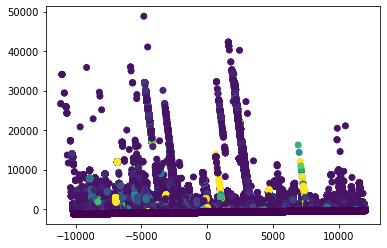

In [ ]:
df = df.fillna(0)
X = df.copy().drop(columns=["item_cnt_month", "date_block_num"])
Y = df.copy().item_cnt_month
pca = PCA(n_components=2)
pca_model = pca.fit(X)
pca_df = pca_model.transform(X)
scatter(pca_df[:, 0], pca_df[:, 1], c=Y)

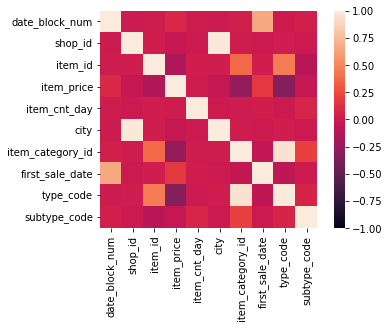

In [ ]:
sns.heatmap(train.corr(), vmin=-1, vmax=1, square=True)

## Modeling

### Preparation Data

Подготовим данные для scikit-learn и для PySpark

In [ ]:
keep_from_month = 2  
valid_month = 33

valid = df.loc[df.date_block_num == valid_month, :]
train = df.loc[df.date_block_num < valid_month, :]
train = train[train.date_block_num >= keep_from_month]
X_train = train.drop(columns="item_cnt_month")
y_train = train.item_cnt_month
X_valid = valid.drop(columns="item_cnt_month")
y_valid = valid.item_cnt_month
test = df.drop(columns="item_cnt_month").loc[df.date_block_num == 34, :]

In [ ]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

spark_dff = sqlContext.createDataFrame(train)

In [ ]:
assembler=VectorAssembler(inputCols=list(X_train.columns),outputCol='features')
output=assembler.transform(spark_dff)
output.select('features','item_cnt_month').show(5)
final_data=output.select('features','item_cnt_month')

+--------------------+--------------+
|            features|item_cnt_month|
+--------------------+--------------+
|[2.0,5.0,20175.0,...|           1.0|
|[2.0,5.0,20083.0,...|           2.0|
|[2.0,2.0,31.0,698...|           1.0|
|[2.0,41.0,2437.0,...|           1.0|
|[2.0,41.0,2417.0,...|           1.0|
+--------------------+--------------+
only showing top 5 rows



In [ ]:
spark_valid_dff = sqlContext.createDataFrame(valid)
assembler=VectorAssembler(inputCols=list(X_valid.columns), outputCol='features')
output=assembler.transform(spark_valid_dff)
output.select('features').show(5)
unlabeled_data=output.select('features')

+--------------------+
|            features|
+--------------------+
|[33.0,45.0,13315....|
|[33.0,45.0,13880....|
|[33.0,45.0,13881....|
|[33.0,45.0,13881....|
|[33.0,45.0,13923....|
+--------------------+
only showing top 5 rows



In [ ]:
spark_test_dff = sqlContext.createDataFrame(test)
assembler=VectorAssembler(inputCols=list(test.columns), outputCol='features')
output=assembler.transform(spark_test_dff)
output.select('features').show(5)
test_data=output.select('features')

+--------------------+
|            features|
+--------------------+
|(17,[0,1,2,4,5,6,...|
|(17,[0,1,2,4,5,6,...|
|(17,[0,1,2,4,5,6,...|
|(17,[0,1,2,4,5,6,...|
|(17,[0,1,2,4,5,6,...|
+--------------------+
only showing top 5 rows



### LinearRegression with PySpark

In [ ]:
lr = LinearRegressionSpark(featuresCol="features", 
                           labelCol='item_cnt_month', 
                           maxIter=10, 
                           regParam=0.3, 
                           elasticNetParam=0.8)

In [ ]:
start = time()
trained_model = lr.fit(final_data)
train_result = trained_model.evaluate(final_data)
end = time()
print('R2:', train_result.r2)
print(f"Time for PySpark LinearRegression {end-start}")

R2: 0.8974333264644969
Time for PySpark LinearRegression 93.00017666816711


In [ ]:
predictions = trained_model.transform(unlabeled_data)
predictions.show(5)

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[33.0,45.0,13315....|1.0342460605366157|
|[33.0,45.0,13880....|3.0304375930331813|
|[33.0,45.0,13881....| 1.598198186899939|
|[33.0,45.0,13881....| 1.598198186899939|
|[33.0,45.0,13923....|0.9965250867572311|
+--------------------+------------------+
only showing top 5 rows



In [ ]:
y_pred = predictions.select("prediction").toPandas()["prediction"]
print('R2:', r2_score(y_valid, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_valid, y_pred))
print('Mean Squared Error:', mean_squared_error(y_valid, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_valid, y_pred)))

R2: 0.9053950180429681
Mean Absolute Error: 0.7401779399972037
Mean Squared Error: 2.4139065857487014
Root Mean Squared Error: 1.553675186694021


### LinearRegression with Sklearn

In [ ]:
reg_model = LinearRegressionSklearn()
start = time()
reg_model = reg_model.fit(X_train, y_train)      
y_pred = reg_model.predict(X_valid) 
end = time()
print(f"Time for Sklearn LinearRegression {end-start}s")

Time for Sklearn LinearRegression 1.492565631866455s


In [ ]:
print('R2:', r2_score(y_valid, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_valid, y_pred))
print('Mean Squared Error:', mean_squared_error(y_valid, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_valid, y_pred)))

R2: 0.9164326365569799
Mean Absolute Error: 0.8110611100018469
Mean Squared Error: 2.132274694163372
Root Mean Squared Error: 1.4602310413641302


### DecisionTree with PySpark

In [ ]:
decision_spark_model = DecisionTreeRegressorSpark(featuresCol="features", 
                                                  labelCol='item_cnt_month', 
                                                  maxDepth=2)

In [ ]:
start = time()
trained_model = decision_spark_model.fit(final_data)
train_result = trained_model.evaluate(final_data)
end = time()
print('R2:', train_result.r2)
print(f"Time for PySpark LinearRegression {end-start}")

R2: 0.90212312441234
Time for Sklearn DecisionTree 105.492565631866455s


In [ ]:
predictions = trained_model.transform(unlabeled_data)
predictions.show(5)

In [ ]:
y_pred = predictions.select("prediction").toPandas()["prediction"]
print('R2:', r2_score(y_valid, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_valid, y_pred))
print('Mean Squared Error:', mean_squared_error(y_valid, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_valid, y_pred)))

R2: 0.9603938597302253
Mean Absolute Error: 0.560393857345302253
Mean Squared Error: 2.052340369749063
Root Mean Squared Error: 2.12363446382141559


### DecisionTree with Sklearn

In [ ]:
start = time()
decision_model = DecisionTreeRegressorSklearn(random_state=0, max_depth=5)
decision_model.fit(X_train, y_train)
y_pred = decision_model.predict(X_valid) 
end = time()
print(f"Time for Sklearn DecisionTree {end-start}s")

Time for Sklearn DecisionTree 11.172292709350586s


In [ ]:
print('R2:', r2_score(y_valid, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_valid, y_pred))
print('Mean Squared Error:', mean_squared_error(y_valid, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_valid, y_pred)))

R2: 0.9271432699489333
Mean Absolute Error: 0.6039385773022532
Mean Squared Error: 1.8589860369749063
Root Mean Squared Error: 1.363446382141559


## Result Submition

In [ ]:
test = test.fillna(0)
sales_prediction = decision_model.predict(test)
test = pd.read_csv(PATH_TO_DATASET + "test.csv")
test_result = pd.DataFrame(sales_prediction)
test_result.columns = ['item_cnt_month']
predict = test_result['item_cnt_month']
sales_predict_submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':predict})
sales_predict_submission.to_csv('submissionSklearn.csv', index=False)

In [ ]:
predictions = trained_model.transform(test_data)
sales_prediction_spark = predictions.select("prediction").toPandas()["prediction"]
test_result = pd.DataFrame(sales_prediction_spark)
test_result.columns = ['item_cnt_month']
predict = test_result['item_cnt_month']
sales_predict_submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month':predict})
sales_predict_submission.to_csv('submissionSpark.csv', index=False)